<a href="https://colab.research.google.com/github/patrick-nanys/text-summarization/blob/main/bert_text_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep learning homework - Milestone 2
#####Topic: NLP - text summarization
#####Authors: Patrick Nanys, Mate Jakab (Goal Diggers)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/Colab\ Notebooks/Deep\ learning/reviews.xlsx reviews.xlsx

###1. Data load from xlsx 

> Source: https://www.kaggle.com/shashichander009/inshorts-news-data
> Source2.0: https://www.kaggle.com/snap/amazon-fine-food-reviews



In [ ]:
import pandas as pd

#xls = pd.read_excel("Inshorts Cleaned Data.xlsx")
xls = pd.read_excel("reviews.xlsx")
xls['headline_type'] = xls['Headline'].apply(type)
xls.drop(xls[xls.headline_type != str].index, inplace=True)
# Load articles, stories
input_raw = xls['Short']
# Load headlines for articles and stories
output_raw = xls['Headline']

# Show example
print(input_raw.head(), output_raw.head())

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Short, dtype: object 0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Headline, dtype: object


In [ ]:
xls.describe()

,Headline,Short,headline_type
count,568427,568427,568427
unique,295742,393576,1
top,Delicious!,"This review will make me sound really stupid, ...",<class 'str'>
freq,2462,199,568427


Obtaining length data

In [ ]:
input_lengths = pd.Series([len(x) for x in input_raw])
output_lengths = pd.Series([len(str(x)) for x in output_raw])
print('Inputs:\n', input_lengths.describe())
print('Outputs:\n', output_lengths.describe())

Inputs:
 count    568427.000000
mean        436.239369
std         445.354882
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
dtype: float64
Outputs:
 count    568427.000000
mean         23.446990
std          14.028431
min           1.000000
25%          13.000000
50%          20.000000
75%          30.000000
max         128.000000
dtype: float64


In [ ]:
# maxlen
# taking values > and round figured to 75th percentile
# at the same time not leaving high variance
encoder_maxlen = 510 + 2
decoder_maxlen = 30 + 2

In [ ]:
def dataset_split(X, Y, valid_split, test_split):
  v_start = int(len(X)*(1-valid_split-test_split))
  t_start = int(len(X)*(1-test_split))
  X_train, Y_train = X[:v_start], Y[:v_start]
  X_valid, Y_valid = X[v_start:t_start], Y[v_start:t_start]
  X_test , Y_test  = X[t_start:], Y[t_start:]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

### Bert tokenization

In [ ]:
!rm -r uncased_L-12_H-768_A-12

In [ ]:
# bert setup

!pip install bert-for-tf2
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

import os
import bert
import tensorflow as tf
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_file = os.path.join(bert_model_name, "bert_model.ckpt")
bert_config_file = os.path.join(bert_model_name, "bert_config.json")

def create_bert_layer():
  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
    bc = StockBertConfig.from_json_string(reader.read())
    bert_params = map_stock_config_to_params(bc)
    bert_params.adapter_size = None
    bert = BertModelLayer.from_params(bert_params, name="bert")
  return bert

# call this after build
#load_stock_weights(bert, bert_ckpt_file)

tokenizer = FullTokenizer(vocab_file=os.path.join(bert_model_name, "vocab.txt"))

--2020-11-26 12:32:09--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   262MB/s    in 1.5s    

2020-11-26 12:32:11 (262 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
import numpy as np
from tqdm.notebook import tqdm

def bert_tokenize(data):
  tokenized_data = []
  for text in tqdm(data):
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    tokenized_data.append(token_ids)
  return tokenized_data

def bert_pad(data, maxlen):
  padded_data = []
  for token_ids in tqdm(data):
    token_ids = token_ids[:min(len(token_ids), maxlen - 2)]
    token_ids = token_ids + [0] * (maxlen - len(token_ids))
    padded_data.append(np.array(token_ids))
  return np.array(padded_data)

def bert_preprocess(data, maxlen):
  print('tokenizing...')
  x = bert_tokenize(data)
  print('padding...')
  x = bert_pad(x, maxlen)
  return x

In [ ]:
print('Preprocessing input')
X = bert_preprocess(input_raw[:50000], encoder_maxlen)
print('Preprocessing output')
Y = bert_preprocess(output_raw[:50000], decoder_maxlen)
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = dataset_split(X, Y, valid_split=0.2, test_split=0.1)

Preprocessing input
tokenizing...



padding...



Preprocessing output
tokenizing...



padding...


In [ ]:
# save preprocessed reviews
import pickle

with open('preprocessed_reviews.pkl', 'wb') as file:
  data = (X, Y)
  pickle.dump(data, file)

!cp preprocessed_reviews.pkl drive/MyDrive/Colab\ Notebooks/Deep\ learning/preprocessed_reviews.pkl

In [ ]:
# load preprocessed reviews
import pickle

!cp drive/MyDrive/Colab\ Notebooks/Deep\ learning/preprocessed_reviews.pkl preprocessed_reviews.pkl

with open('preprocessed_reviews.pkl', 'rb') as file:
  data = pickle.load(file)

nX, nY = data
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = dataset_split(nX, nY, valid_split=0.2, test_split=0.1)

In [ ]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

((35000, 512), (35000, 32), (10000, 512), (10000, 32), (5000, 512), (5000, 32))

In [ ]:
X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]

50000

In [ ]:
x_vocab = len(tokenizer.vocab)
y_vocab = len(tokenizer.vocab)
x_vocab, y_vocab

(30522, 30522)

In [ ]:
X[:32].shape, Y[:32].shape

((32, 512), (32, 32))

# Training

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Attention, Dropout, Conv1D, Flatten

### Architecture

In [ ]:
embedding_dim = 250 #50
hidden_dim = 250 #60

ENC_LSTM_NUM = 3 #3
ENC_LSTM_DROPOUT = 0.4 #0.4
ENC_LSTM_RECURRENT_DROPOUT = 0.4 #0.4

CONV_FILTERS = 32
CONV_KERNEL_SIZE = 3

# Architecture

bert_layer = create_bert_layer()
bert_layer.trainable = False

# Encoder
enc_emb = bert_layer
#enc_emb = Embedding(x_vocab, embedding_dim)
enc_lstms = []
for i in range(ENC_LSTM_NUM):
  enc_lstms.append(LSTM(hidden_dim, return_sequences=True, return_state=True))
dropout = Dropout(ENC_LSTM_DROPOUT)

# Decoder
#dec_emb = bert_layer
dec_emb = Embedding(y_vocab, embedding_dim)
dec_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
attn = Attention()
concat = Concatenate()
conv1d = Conv1D(CONV_FILTERS, CONV_KERNEL_SIZE, activation='relu')
dec_fc = Dense(y_vocab, activation='softmax')

### Building the model

In [ ]:
# Building the model

# Encoder
encoder_input = Input(shape=(encoder_maxlen,))
enc_emb_out = enc_emb(encoder_input)
lstm_in = enc_emb_out
for i in range(ENC_LSTM_NUM):
  lstm_out, h, c = enc_lstms[i](lstm_in)
  lstm_out = dropout(lstm_out)
  lstm_in = lstm_out
enc_output, enc_state_h, enc_state_c = enc_lstms[-1](lstm_in)
 
# Decoder
decoder_input = Input(shape=(None,))
dec_emb_out = dec_emb(decoder_input)
dec_output, dec_state_h, dec_state_c = dec_lstm(dec_emb_out, initial_state=[enc_state_h, enc_state_c])

attn_out = attn([dec_output, enc_output])
conv_out = concat([dec_output, attn_out])
output = dec_fc(conv_out)

model = Model([encoder_input, decoder_input], output)

load_stock_weights(bert_layer, bert_ckpt_file)

model.summary()

Done loading 196 BERT weights from: uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd6760b34e0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512)]        0                                            
________________________________________________

### Rouge loss function


In [ ]:
import keras.backend as K

def n_grams(n, text):
  return [tuple(text[i:i+n]) for i in range(len(text)-n+1)]

def rouge(y, y_pred):
  total_words_in_reference = len(y)
  recalls = []
  for i in range(1, 4):
    target_n_grams = set(np.vectorize(n_grams(i, y)))
    pred_n_grams = set(np.vectorize(n_grams(i, y_pred)))
    number_of_overlapping = target_n_grams.intersection(pred_n_grams)
    recalls.append(number_of_overlapping / total_words_in_reference)
  return K.mean(recalls)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
!cp drive/MyDrive/Colab\ Notebooks/Deep\ learning/bert_model.hdf5 bert_model.hdf5
model.load_weights('bert_model.hdf5')

### Training

In [ ]:
def get_model_input(X, Y):
  """
    List of X and Y where Ys last word is excluded
  """
  return [X, Y[:,:-1]]

def get_model_output(Y):
  """
    Y input shifted right (first word excluded) and made it third dimensional
  """
  return Y.reshape(Y.shape[0],Y.shape[1], 1)[:,1:]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

PATIENCE = 3
SAVED_MODEL_PATH = 'bert_model.hdf5'

earlystopping = EarlyStopping(patience=PATIENCE, monitor='val_loss', mode='min', verbose=1)
checkpointer = ModelCheckpoint(filepath=SAVED_MODEL_PATH, save_best_only=True, verbose=0)

In [ ]:
history = model.fit(
    get_model_input(X_train, Y_train),
    get_model_output(Y_train),
    epochs=3, #20
    batch_size=32, #32,
    validation_data=(
        get_model_input(X_valid, Y_valid),
        get_model_output(Y_valid)
        ),
    callbacks=[checkpointer, earlystopping]
    )

Epoch 1/3
1094/1094 [==============================] - 2465s 2s/step - loss: 0.8159 - val_loss: 0.9827
Epoch 2/3
1094/1094 [==============================] - 2460s 2s/step - loss: 0.8019 - val_loss: 0.9862
Epoch 3/3
1094/1094 [==============================] - 2460s 2s/step - loss: 0.7928 - val_loss: 0.9909


loss: 1.2703 - val_loss: 1.1933

loss: 1.0352 - val_loss: 1.0634

loss: 0.9740 - val_loss: 1.0341

loss: 0.9354 - val_loss: 1.0127

loss: 0.9093 - val_loss: 1.0061

loss: 0.8868 - val_loss: 0.9943

loss: 0.8670 - val_loss: 0.9894

loss: 0.8480 - val_loss: 0.9853

loss: 0.8321 - val_loss: 0.9849

loss: 0.8159 - val_loss: 0.9827

loss: 0.8019 - val_loss: 0.9862

loss: 0.7928 - val_loss: 0.9909

In [ ]:
model.load_weights(SAVED_MODEL_PATH)

In [ ]:
# save model
!\cp bert_model.hdf5 drive/MyDrive/Colab\ Notebooks/Deep\ learning/bert_model.hdf5

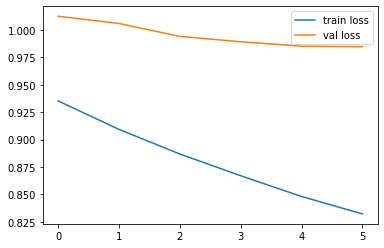

In [ ]:
import seaborn as sns

sns.lineplot(data=history.history['loss'], label='train loss')
sns.lineplot(data=history.history['val_loss'], label='val loss')

# Inference

In [ ]:
# Encode
encoder_model = Model(encoder_input, [enc_output, enc_state_h, enc_state_c])

# Inputs for decode
dec_state_input_h = Input(shape=(hidden_dim,))
dec_state_input_c = Input(shape=(hidden_dim,))
dec_hidden_state_input = Input(shape=(encoder_maxlen, hidden_dim))

# Decode
dec_emb_out2 = dec_emb(decoder_input)
dec_output2, dec_state_h2, dec_state_c2 = dec_lstm(dec_emb_out2, initial_state=[dec_state_input_h, dec_state_input_c])
attn_out2 = attn([dec_output2, dec_hidden_state_input])
concat_out2 = concat([dec_output2, attn_out2])
output = dec_fc(concat_out2)

decoder_model = Model([decoder_input] + [dec_hidden_state_input, dec_state_input_h, dec_state_input_c], [output] + [dec_state_h2, dec_state_c2])

In [ ]:
reverse_target_word_index=tokenizers[1].index_word
reverse_source_word_index=tokenizers[0].index_word
target_word_index=tokenizers[1].word_index

In [ ]:
reverse_target_word_index=lambda x: tokenizer.convert_ids_to_tokens([x])[0]
reverse_source_word_index=lambda x: tokenizer.convert_ids_to_tokens([x])[0]
target_word_index=lambda x: tokenizer.convert_tokens_to_ids([x])[0]

In [ ]:
import numpy as np

def decode_sequence(input_seq):
  e_out, e_h, e_c = encoder_model.predict(input_seq)

  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = target_word_index('[CLS]')

  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:

    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

    # sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    try:
      sampled_token = reverse_target_word_index(sampled_token_index)
    except:
      sampled_token = '[UNK]'

    if(sampled_token!='[SEP]'):
      decoded_sentence += ' '+sampled_token

    # Exit condition: either hit max length or find stop word.
    if (sampled_token == '[SEP]'  or len(decoded_sentence.split()) >= (decoder_maxlen - 1)):
      stop_condition = True

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # Update internal states
    e_h, e_c = h, c

  return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for item in input_seq:
        if(item != 0 and item != target_word_index('[CLS]') and item != target_word_index('[SEP]')):
          try:
            new_str = reverse_target_word_index(item)
          except:
            new_str = '[UNK]'
          newString = newString + new_str + ' '
    return newString

def seq2text(input_seq):
    newString=''
    for item in input_seq:
      if(item != 0):
        try:
          new_str = reverse_source_word_index(item)
        except:
          new_str = '[UNK]'
        newString = newString + new_str + ' '
    return newString

In [ ]:
for i in range(20):
    print("Text:",seq2text(X_train[i]))
    print("Original title:",seq2summary(Y_train[i]))
    print("Predicted title:",decode_sequence(X_train[i].reshape(1, -1)))
    print("\n")

Text: [CLS] i have bought several of the vital ##ity canned dog food products and have found them all to be of good quality . the product looks more like a stew than a processed meat and it smells better . my labrador is fin ##ick ##y and she appreciate ##s this product better than most . [SEP] 
Original title: good quality dog food 
Predicted title:  great dog food


Text: [CLS] product arrived labeled as ju ##mbo salt ##ed peanuts . . . the peanuts were actually small sized un ##sal ##ted . not sure if this was an error or if the vendor intended to represent the product as " ju ##mbo " . [SEP] 
Original title: not as advertised 
Predicted title:  not as good as the money


Text: [CLS] this is a con ##fect ##ion that has been around a few centuries . it is a light , pillow ##y citrus gel ##atin with nuts - in this case fi ##lbert ##s . and it is cut into tiny squares and then liberal ##ly coated with powder ##ed sugar . and it is a tiny mouthful of heaven . not too chew ##y , and very